![image](image/屏幕截图%202025-03-01%20213414.png)

In [6]:
import gymnasium as gym
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import rl_utils

In [7]:
class PolicyNet(torch.nn.Module):
    """
    输入是一个状态, 输出是该状态下动作的可见分布
    """
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(PolicyNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return F.softmax(self.fc2(x), dim=1)
    
class ValueNet(torch.nn.Module):
    '''
    输入是一个状态, 输出是状态的价值 
    使用时序差分作为loss目标
    '''
    def __init__(self, state_dim, hidden_dim):
        super(ValueNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)

In [8]:
class ActorCritic:
    def __init__(self, state_dim, hidden_dim, action_dim, actor_lr, critic_lr, gamma, device):
        self.actor = PolicyNet(state_dim, hidden_dim, action_dim).to(device)
        self.critic = ValueNet(state_dim, hidden_dim).to(device)  

        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(),lr=actor_lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(),lr=critic_lr)  # 价值网络优化器
        self.gamma = gamma
        self.device = device

    def take_action(self,state):
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        probs = self.actor(state)
        action_dist = torch.distributions.Categorical(probs)
        action = action_dist.sample()
        return action.item()
    
    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'],dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'],dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'],dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'],dtype=torch.float).view(-1, 1).to(self.device)

        #时序差分目标:
        td_target = rewards + self.gamma * self.critic(next_states)  * (1 - dones)
        td_delta = td_target - self.critic(states)
        log_probs = torch.log(self.actor(states).gather(1, actions))
        actor_loss = torch.mean(-log_probs * td_delta.detach())

        #均方误差损失函数
        critic_loss = torch.mean(F.mse_loss(td_target.detach(),self.critic(states)))
        self.actor_optimizer.zero_grad()
        self.critic_optimizer.zero_grad()
        actor_loss.backward()
        critic_loss.backward()
        self.actor_optimizer.step()
        self.critic_optimizer.step()

In [ ]:
actor_lr = 1e-3
critic_lr = 1e-2
num_episodes = 1800  #版本更新, 更多trial才能收敛
hidden_dim = 128
gamma = 0.99
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

env_name = 'CartPole-v1'
env = gym.make(env_name)

torch.manual_seed(0)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
agent = ActorCritic(state_dim, hidden_dim, action_dim, actor_lr, critic_lr,gamma, device)

return_list = rl_utils.train_on_policy_agent(env, agent, num_episodes)

Iteration 9: 100%|██████████| 180/180 [01:29<00:00,  2.02it/s, episode=1800, return=500.000]


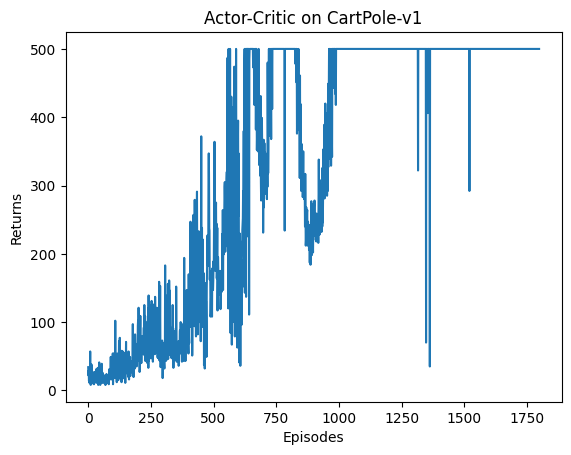

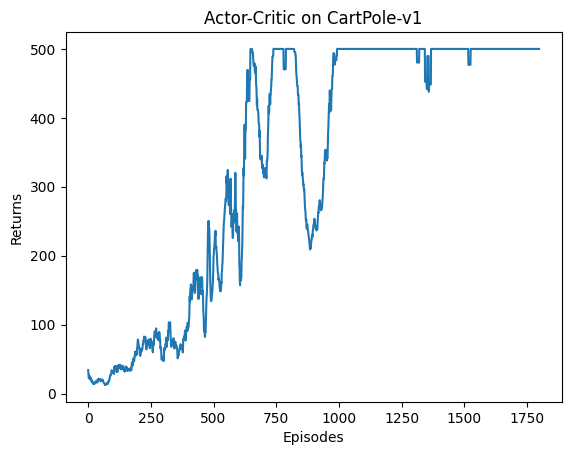

In [14]:
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('Actor-Critic on {}'.format(env_name))
plt.show()

mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('Actor-Critic on {}'.format(env_name))
plt.show()

### 尝试总结今天所学

与reinforce 算法相比, 就是把用蒙特卡洛方法估计Q(s,a) 换成了使用神经网络方法估计Q(s,a). 今天所学是使用时序差分残差代替蒙特卡洛方法的Q(s,a)(或者说G_t)
   
具体critic网络的做法与时序差分章节做法一致.

**关键优势**

低方差：Critic提供的方差比蒙特卡洛回报方差更低。

实时更新：每一步都能更新（不同于回合更新的REINFORCE）。

策略-值解耦：Actor和Critic独立更新，提升稳定性。




Actor-Critic 算法之所以能够实现**实时更新**（即每一步都能更新），而 REINFORCE 必须等待整个回合结束才能更新，核心原因在于两者对**价值估计**和**梯度计算**的方式不同。以下是详细解释：

---

### **1. REINFORCE 的回合更新机制**
REINFORCE 是纯粹的蒙特卡洛（Monte Carlo）方法，其更新依赖于**完整回合的轨迹**：
- **步骤**：
  1. 执行整个回合（直到终止状态），收集所有状态、动作、奖励。
  2. 计算每个时刻的**蒙特卡洛回报**（即从当前时刻到回合结束的累计折扣奖励）：
     $$
     G_t = \sum_{k=t}^{T} \gamma^{k-t} r_k
     $$
  3. 用 $G_t$ 作为权重，更新策略梯度：
     $$
     \nabla_\theta J(\theta) = \mathbb{E} \left[ G_t \nabla_\theta \log \pi_\theta(a_t|s_t) \right]
     $$

- **关键问题**：
  - 必须等待回合结束才能计算 $G_t$，无法实时更新。
  - $G_t$ 的方差较大（依赖整条轨迹的随机性），导致训练不稳定。

---

### **2. Actor-Critic 的实时更新机制**
Actor-Critic 通过引入 Critic 网络，用**时序差分（Temporal Difference, TD）**方法替代蒙特卡洛回报，实现单步更新：

#### **(1) Critic 的作用**
Critic 网络估计状态值函数 $V(s)$，给出当前状态 $s_t$ 的实时价值评估，并通过 TD 误差更新：
- **TD 误差**：
  $$
  \delta_t = r_t + \gamma V(s_{t+1}) - V(s_t)
  $$
  - $r_t + \gamma V(s_{t+1})$：对当前奖励和下一状态价值的估计。
  - $V(s_t)$：Critic 对当前状态的估计值。
  
- **Critic 的更新**：
  $$
  \text{更新目标：最小化 } \delta_t^2
  $$

#### **(2) Actor 的更新**
Actor 直接利用 TD 误差 $\delta_t$ 作为策略梯度的权重：
- **策略梯度**：
  $$
  \nabla_\theta J(\theta) = \mathbb{E} \left[ \delta_t \nabla_\theta \log \pi_\theta(a_t|s_t) \right]
  $$
  - $\delta_t$ 替代了蒙特卡洛回报 $G_t$，成为动作优势的估计。

#### **(3) 实时更新的流程**
1. **每一步执行**：
   - 在状态 $s_t$，Actor 选择动作 $a_t$。
   - 环境返回奖励 $r_t$ 和下一状态 $s_{t+1}$。
   
2. **立即计算 TD 误差**：
   $$
   \delta_t = r_t + \gamma V(s_{t+1}) - V(s_t)
   $$

3. **更新 Critic**：
   - 优化 Critic 网络参数，使得 $V(s_t)$ 更接近 $r_t + \gamma V(s_{t+1})$。

4. **更新 Actor**：
   - 用 $\delta_t$ 加权策略梯度，调整 $\pi_\theta(a|s)$，增加高 $\delta_t$ 动作的概率。

---

### **3. 为什么能实时更新？**
- **无需等待回合结束**：TD 误差 $\delta_t$ 仅依赖当前奖励 $r_t$ 和下一状态 $s_{t+1}$ 的价值估计 $V(s_{t+1})$，而 $V(s_{t+1})$ 由 Critic 实时提供。
- **在线学习**：每一步的数据 $(s_t, a_t, r_t, s_{t+1})$ 可立即用于更新网络。
- **自举（Bootstrapping）**：Critic 的更新利用了自身对后续状态的估计（$V(s_{t+1})$），而不是等待实际回报。

---

### **对比表格**
| 特性                | REINFORCE (蒙特卡洛)               | Actor-Critic (时序差分)         |
|---------------------|-----------------------------------|---------------------------------|
| **更新时机**         | 回合结束后更新                     | 每一步实时更新                  |
| **价值估计**         | 蒙特卡洛回报 $G_t$                 | TD 误差 $\delta_t$             |
| **方差**             | 高（依赖整条轨迹）                 | 低（仅依赖单步奖励和估计值）     |
| **适用场景**         | 回合较短的环境                     | 回合较长或连续任务              |
| **训练效率**         | 低（延迟更新）                     | 高（实时更新）                  |

---

### **通俗例子：赛车游戏**
- **REINFORCE**：跑完整场比赛后，根据最终名次（$G_t$）调整每个弯道的驾驶策略。如果中途犯错，必须等到比赛结束才能修正。
- **Actor-Critic**：每过一个弯道，立即根据当前速度（$V(s_t)$）和过弯后的位置（$V(s_{t+1})$）调整策略。如果过弯时打滑（$\delta_t$ 为负），立刻修正方向盘角度。

---

### **数学总结**
Actor-Critic 的实时更新能力源于：
1. **Critic 的 TD 误差**：$\delta_t = r_t + \gamma V(s_{t+1}) - V(s_t)$ 是局部、即时的反馈信号。
2. **Actor 的在线梯度更新**：$\nabla_\theta J(\theta) \propto \delta_t \nabla_\theta \log \pi_\theta(a_t|s_t)$，每一步的 $\delta_t$ 均可用于更新。

这种设计使 Actor-Critic 在复杂、长期任务中比 REINFORCE 更高效稳定，成为深度强化学习的核心框架之一（如 PPO、A3C 均基于此）。